In [1]:
import pandas as pd
import numpy as np

# Make TPM matrix

## Experiments list

In [2]:
experiments = pd.read_csv(
    "../data/intermediate/experiment_setup.txt", sep="\t")

experiments["kallisto_path"] = "../data/intermediate/kallisto_quant/" + \
    experiments["sample"]+"/abundance.tsv"


def load_tpms(exp_path, exp_name):
    abundances = pd.read_csv(exp_path, sep="\t", index_col=0)

    tpms = abundances["tpm"]
    tpms = tpms.rename(exp_name)
    tpms = tpms.astype(np.float64)

    return tpms

## Merge TPMs

In [3]:
exps = zip(experiments["kallisto_path"], experiments["sample"])

transcript_tpms = [load_tpms(x[0], x[1]) for x in exps]

transcript_tpms = pd.concat(transcript_tpms, axis=1)

transcript_tpms.to_csv("../data/processed/transcript_tpms.txt", sep="\t")

# Transcripts to genes

In [4]:
t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv")

transcript_gene_map = dict(zip(t2g["target_id"], t2g["ens_gene"]))

## Sum transcripts by genes

In [5]:
_, align_ensembl_genes = transcript_tpms.align(t2g.set_index(
    "target_id")["ens_gene"], axis=0, join="inner")

gene_tpms = transcript_tpms.groupby(align_ensembl_genes).sum()

gene_tpms.to_csv("../data/processed/gene_tpms.txt", sep="\t")

# Sleuth outputs

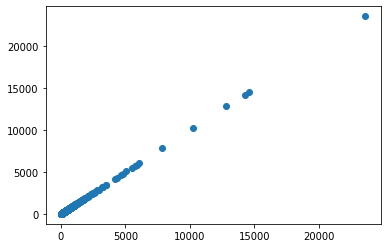

In [15]:
import matplotlib.pyplot as plt
plt.scatter(transcript_tpms["NCIH2110_RPL22-1A1_2"],transcript_tpms["NCIH2110_RPL22-4A1_2"])

In [13]:
transcript_tpms.loc["ENST00000295830"]

LNCaP_GFP_1             38.00170
LNCaP_GFP_2             33.93350
LNCaP_GFP_3             35.89380
LNCaP_RPL22_1            7.40500
LNCaP_RPL22_2            6.67507
LNCaP_RPL22_3            8.05611
CAL851_GFP_1             1.25015
CAL851_GFP_2             1.69996
CAL851_GFP_3             1.30957
CAL851_RPL22L1_1        17.91760
CAL851_RPL22L1_2        30.25630
CAL851_RPL22L1_3        18.05240
LNCaP_shLuc_1           56.32210
LNCaP_shLuc_2           61.15030
LNCaP_shLuc_3           61.89870
LNCaP_sh704_1            9.90730
LNCaP_sh704_2            9.31612
LNCaP_sh704_3            8.30557
LNCaP_sh705_1            6.54853
LNCaP_sh705_2            7.74621
LNCaP_sh705_3            8.47731
NCIH2110_GFP_1           1.62576
NCIH2110_GFP_2           2.42698
NCIH2110_GFP_3           2.11737
NCIH2110_RPL22-1A1_1    66.98440
NCIH2110_RPL22-1A1_2    28.11670
NCIH2110_RPL22-1A1_3    42.36370
NCIH2110_RPL22-4A1_1    40.05260
NCIH2110_RPL22-4A1_2    28.12850
NCIH2110_RPL22-4A1_3    42.35610
Name: ENST

In [7]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
],
    "rpl22_1a1": [
    ['NCIH2110_GFP_1',
     'NCIH2110_GFP_2',
     'NCIH2110_GFP_3'],
    ['NCIH2110_RPL22-1A1_1',
     'NCIH2110_RPL22-1A1_2',
     'NCIH2110_RPL22-1A1_3']
],
    "rpl22_4a1": [
    ['NCIH2110_GFP_1',
     'NCIH2110_GFP_2',
     'NCIH2110_GFP_3'],
    ['NCIH2110_RPL22-4A1_1',
     'NCIH2110_RPL22-4A1_2',
     'NCIH2110_RPL22-4A1_3']
]
}

experiment_ids = ["rpl22_oe", "rpl22l1_oe", "sh704", "sh705", "rpl22_1a1", "rpl22_4a1"]

In [8]:
def compute_medians(sleuth_diff, experiment):
    sleuth_diff["control_median"] = sleuth_diff[experiments[experiment][0]].median(axis=1)
    sleuth_diff["treatment_median"] = sleuth_diff[experiments[experiment][1]].median(axis=1)
    sleuth_diff["median_foldchange"] = sleuth_diff["treatment_median"]/sleuth_diff["control_median"]
    
def signed_p_rank(sleuth_diff):

    sleuth_diff["-log_pval"] = -np.log10(sleuth_diff["pval"])
    sleuth_diff["-log_pval"] = sleuth_diff["-log_pval"].replace(np.inf,320)
    
    sleuth_diff["treatment_increase"] = -1 + 2*(sleuth_diff["median_foldchange"] > 1)
    
    sleuth_diff["signed_pval"] = sleuth_diff["-log_pval"] * sleuth_diff["treatment_increase"]
    
    sleuth_diff = sleuth_diff.sort_values(by="signed_pval")

In [9]:
def process_sleuth_genes(experiment):
    sleuth_diff = pd.read_csv("../data/intermediate/sleuth_diff/"+experiment+"_genes.csv",index_col=1)
        
    controls = experiments[experiment][0]
    treatments = experiments[experiment][1]
    
    sleuth_tpms = gene_tpms.loc[sleuth_diff.index,controls+treatments]
    
    sleuth_diff = pd.concat([sleuth_diff, sleuth_tpms], axis=1)
    
    compute_medians(sleuth_diff, experiment)
    signed_p_rank(sleuth_diff)
    
    sleuth_diff = sleuth_diff.dropna(subset=["pval","median_foldchange","target_id"],how="any")
    
    # format Entrez ID as string
    sleuth_diff["target_id"] = sleuth_diff["target_id"].astype(int).astype(str)

    sleuth_diff.to_csv("../data/processed/kallisto_sleuth_merge/"+experiment+"_genes.txt",sep="\t")

In [10]:
def process_sleuth_transcripts(experiment):
    sleuth_diff = pd.read_csv("../data/intermediate/sleuth_diff/"+experiment+"_transcripts.csv",index_col=1)
        
    controls = experiments[experiment][0]
    treatments = experiments[experiment][1]
    
    sleuth_tpms = transcript_tpms.loc[sleuth_diff.index,controls+treatments]
    
    sleuth_diff = pd.concat([sleuth_diff, sleuth_tpms], axis=1)
    
    compute_medians(sleuth_diff, experiment)
    signed_p_rank(sleuth_diff)
    
    sleuth_diff = sleuth_diff.dropna(subset=["pval","median_foldchange","entrez_gene"],how="any")
    
    # format Entrez ID as string
    sleuth_diff["entrez_gene"] = sleuth_diff["entrez_gene"].astype(int).astype(str)

    sleuth_diff.to_csv("../data/processed/kallisto_sleuth_merge/"+experiment+"_transcripts.txt",sep="\t")    

In [12]:
for exp_id in experiment_ids:
    
    print(exp_id)
    
    process_sleuth_genes(exp_id)
    process_sleuth_transcripts(exp_id)

rpl22_oe


/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


rpl22l1_oe
sh704
sh705
rpl22_1a1
rpl22_4a1
